In [ ]:
### Adapted from: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [2]:
 # Libraries
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
import torch.nn.functional as F
from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader
import torch.backends.cudnn as cudnn

import sklearn.metrics
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [40]:
# dictionary of channel means and std. devs. for normalization
datasets = {'ORIGA': {'means': [0.8838386, 0.54816394, 0.26245996], 'stds': [0.0874888, 0.11906112, 0.09120588]},
            'REFUGE': {'means': [0.66341796, 0.43719301, 0.29155903], 'stds': [0.16775985, 0.14277969, 0.09243343]},
            'ACRIMA': {'means': [0.72563578, 0.37745064, 0.09958277], 'stds': [0.09922888, 0.10618329, 0.05055466]},
            'RIM-ONE': {'means': [0.58595025, 0.26142626, 0.14453408], 'stds': [0.11523398, 0.09373888, 0.04623389]},
            'ACRIMA_PRC': {'means': [0.82155978, 0.52809488, 0.29960701], 'stds': [0.12793836, 0.16720517, 0.19120541]},
            'ORIGA_PRC': {'means': [0.87167269, 0.60586608, 0.30907322], 'stds': [0.11139705, 0.15939074, 0.2014417]},
            'REFUGE_PRC': {'means': [0.74798278, 0.55421032, 0.41521491], 'stds': [0.17170242, 0.18160581, 0.19234265]},
            'RIM-ONE_PRC': {'means': [0.76263957, 0.46759289, 0.38662256], 'stds': [0.15323331, 0.1730633, 0.1824202]},
            'IMAGENET': {'means': [0.485, 0.456, 0.406], 'stds': [0.229, 0.224, 0.225]}}

# dictionary of best finetuned model paths
paths = {'ACRIMA': '/content/drive/MyDrive/Thesis/trained_models/ResNet101_ACRIMA_Nov19.pt',
         'ORIGA': '/content/drive/MyDrive/Thesis/trained_models/ResNet101_ORIGA_Nov24.pt',
         'REFUGE': '/content/drive/MyDrive/Thesis/trained_models/ResNet101_REFUGE_Nov29.pt',
         'RIM-ONE': '/content/drive/MyDrive/Thesis/trained_models/ResNet101_RIM-ONE_Nov21.pt',
         'ACRIMA_PRC': '/content/drive/MyDrive/Thesis/trained_models/ResNet101_ACRIMA_PRC_40eps_Feb3.pt',
         'ORIGA_PRC': '/content/drive/MyDrive/Thesis/trained_models/ResNet101_ORIGA_PRC_40eps_Feb3.pt',
         'REFUGE_PRC': '/content/drive/MyDrive/Thesis/trained_models/ResNet101_REFUGE_PRC_40eps_Feb3.pt',
         'RIM-ONE_PRC': '/content/drive/MyDrive/Thesis/trained_models/ResNet101_RIM-ONE_PRC_40eps_Feb3.pt',}

------------------------------------------
**Training (finetuning) model**

In [8]:
#### ONLY USE THIS SECTION FOR NEW DATASETS ####
# function to calculate mean & std. dev. for each channel of dataset, with PyTorch Tensors as input
def calc_norms(data):
  mean_arr = np.zeros((len(data),3))
  std_arr = np.zeros((len(data),3))
  for i in range(len(data)):
    mean = torch.mean(data[i][0], dim=(1,2))
    std = torch.std(data[i][0], dim=(1,2))
    mean_arr[i] = mean
    std_arr[i] = std
  channel_means = np.mean(mean_arr, axis=0)
  channel_stds = np.mean(std_arr, axis=0)
  return channel_means, channel_stds

dataset = 'RIM-ONE_PRC'

# load unnormalized training data
train_dir = '/content/drive/MyDrive/Thesis/' + dataset + '_ROI/train/'
train_data = ImageFolder(train_dir, transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()]))

# calculate and print channel means and std. devs. (then add to dictionary)
means, stds = calc_norms(train_data)
print("Means: ", means)
print("Std. dev.: ", stds)
### END OF SECTION ###

Means:  [0.76263957 0.46759289 0.38662256]
Std. dev.:  [0.15323331 0.1730633  0.1824202 ]


In [35]:
dataset = 'RIM-ONE_PRC'

# load data
train_dir = '/content/drive/MyDrive/Thesis/' + dataset + '_ROI/train/'
test_dir = '/content/drive/MyDrive/Thesis/' + dataset + '_ROI/test/'
val_dir = '/content/drive/MyDrive/Thesis/' + dataset + '_ROI/val/'

# resize and normalize for training
train_data = ImageFolder(train_dir, transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(), transforms.Normalize(mean=datasets[dataset]['means'], std=datasets[dataset]['stds'])]))
val_data = ImageFolder(val_dir, transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(), transforms.Normalize(mean=datasets[dataset]['means'], std=datasets[dataset]['stds'])]))
test_data = ImageFolder(test_dir, transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(), transforms.Normalize(mean=datasets[dataset]['means'], std=datasets[dataset]['stds'])]))

In [36]:
# split into batches
batch_size = 32

train_loader = DataLoader(dataset=train_data, batch_size = batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size = batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size = batch_size, shuffle=True)

dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}

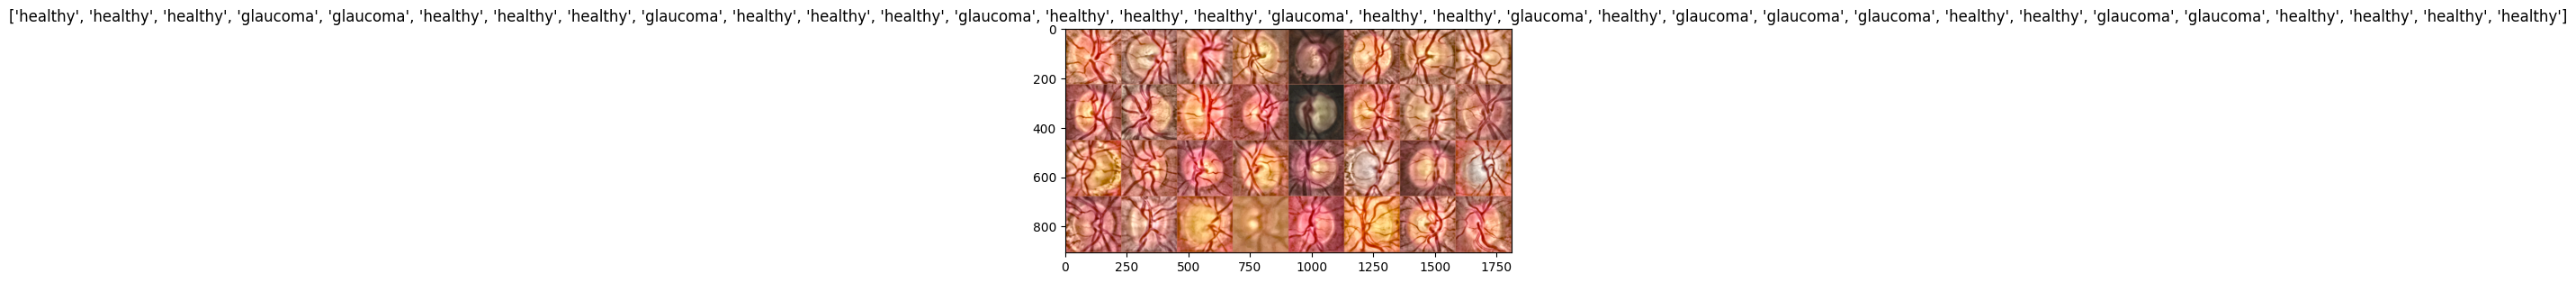

In [37]:
# visualize training images (directly from PyTorch tutorial)
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array(datasets[dataset]['means'])
    std = np.array(datasets[dataset]['stds'])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

class_names = ['healthy', 'glaucoma']
#class_names = ['ACRIMA', 'RIM-ONE', 'ORIGA', 'REFUGE']

imshow(out, title=[class_names[x] for x in classes])

In [6]:
# training step (directly from PyTorch tutorial)
def train_model(model, criterion, optimizer, num_epochs):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                epoch_loss = running_loss / len(dataloaders[phase].dataset)
                epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc >= best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
        torch.save(model.state_dict(), '/content/drive/MyDrive/Thesis/ResNet101.pt')
    return model

In [38]:
## FINE-TUNING & FEATURE EXTRACTION ##
# model parameters
num_epochs = 40
num_cls = 2

# load model from PyTorch
model = models.resnet101(weights='DEFAULT')

# re-initialize final fully-connected layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_cls)

model = model.to(device)

# define loss and optimizer
criterion = nn.CrossEntropyLoss(weight=None)
optimizer_ft = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))

In [39]:
# train model
model = train_model(model, criterion, optimizer_ft, num_epochs=num_epochs)
# save state dictionary
torch.save(model.state_dict(), '/content/drive/MyDrive/Thesis/trained_models/ResNet101_' + dataset + '_40eps_Feb3.pt')

Epoch 0/39
----------
train Loss: 0.5294 Acc: 0.7321
val Loss: 0.6922 Acc: 0.7755

Epoch 1/39
----------
train Loss: 0.2249 Acc: 0.9184
val Loss: 2.0771 Acc: 0.8776

Epoch 2/39
----------
train Loss: 0.1261 Acc: 0.9439
val Loss: 0.8149 Acc: 0.7959

Epoch 3/39
----------
train Loss: 0.3129 Acc: 0.9082
val Loss: 1.5497 Acc: 0.8367

Epoch 4/39
----------
train Loss: 0.1886 Acc: 0.9362
val Loss: 0.6596 Acc: 0.8980

Epoch 5/39
----------
train Loss: 0.1405 Acc: 0.9668
val Loss: 0.4049 Acc: 0.8571

Epoch 6/39
----------
train Loss: 0.2018 Acc: 0.9235
val Loss: 2.8993 Acc: 0.7347

Epoch 7/39
----------
train Loss: 0.1332 Acc: 0.9464
val Loss: 0.5972 Acc: 0.8571

Epoch 8/39
----------
train Loss: 0.0457 Acc: 0.9923
val Loss: 0.4927 Acc: 0.8163

Epoch 9/39
----------
train Loss: 0.0319 Acc: 0.9898
val Loss: 0.4766 Acc: 0.8571

Epoch 10/39
----------
train Loss: 0.0231 Acc: 0.9949
val Loss: 0.4853 Acc: 0.8980

Epoch 11/39
----------
train Loss: 0.0205 Acc: 0.9898
val Loss: 0.6128 Acc: 0.8367

Ep

---------------------------------
**Testing with finetuned model**

In [9]:
# function to test model and get predictions and labels
def collect_preds(model, test_loader):
    model.to(device)
    was_training = model.training
    # evaluation mode
    model.eval()

    # save in lists
    preds_list = []
    labels_list = []

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # model predicts on minibatch
            outputs = model(inputs)
            # choose class with maximum score
            _, preds = torch.max(outputs, 1)

            # add predictions and labels to full list
            preds_list += preds.tolist()
            labels_list += labels.tolist()
        model.train(mode=was_training)

    return preds_list, labels_list

# function to test model and get AUC score, ROC metrics
def collect_auc_roc(model, test_loader):
    model.to(device)
    was_training = model.training
    # evaluation mode
    model.eval()

    # save as tensors
    labels_list = torch.tensor(())
    softmax_list = torch.tensor(())

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # model predicts on minibatch
            outputs = model(inputs)
            # convert predictions to softmax
            softmaxs = F.softmax(outputs, dim=1)
            softmaxs.to(device)

            # add softmax and labels to full tensor
            softmax_list = torch.cat((softmax_list.to(device), softmaxs), 0)
            labels_list = torch.cat((labels_list.to(device), labels), 0)

        model.train(mode=was_training)

    # calculate AUC score, FPR and TPR rates for ROC curve from labels and softmax predictions

    labels_list = labels_list.cpu()
    softmax_list = softmax_list.cpu()

    score = roc_auc_score(labels_list, softmax_list[:,1])
    fpr, tpr, _ = roc_curve(labels_list, softmax_list[:,1])

    return score, fpr, tpr

# function to get confusion matrix metrics from predictions and labels
def acc_and_confusion(preds_list, labels_list):
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    total = len(preds_list)

    for i in range(len(preds_list)):
        # correct class
        if preds_list[i] == labels_list[i]:
            if preds_list[i] == 1 and labels_list[i] == 1: tp += 1
            elif preds_list[i] == 0 and labels_list[i] == 0: tn += 1
            # ensure all predictions are sorted
            else: print("equal not true")

        # incorrect class
        if preds_list[i] != labels_list[i]:
            if preds_list[i] == 1 and labels_list[i] == 0: fp += 1
            elif preds_list[i] == 0 and labels_list[i] == 1: fn += 1
            # ensure all predictions are sorted
            else: print("unequal not true")

    # calculate accuracy
    acc = (tp + tn) / total
    assert total == tp+tn+fp+fn

    return acc, tp, tn, fp, fn

In [41]:
finetuned = 'RIM-ONE_PRC'

# trained model path
path = paths[finetuned]

# load trained model
model = models.resnet101(weights='DEFAULT')
num_ftrs = model.fc.in_features
num_cls = 2
model.fc = nn.Linear(num_ftrs, num_cls)
model.load_state_dict(torch.load(path))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [42]:
# TEST ON ALL DATASETS
test_sets = ['ACRIMA_PRC', 'ORIGA_PRC', 'REFUGE_PRC', 'RIM-ONE_PRC']

for test_set in test_sets:
  test_dir = '/content/drive/MyDrive/Thesis/' + test_set + '_ROI/test/'

  # load and normalize test set by training means and std. devs.
  test_data = ImageFolder(test_dir, transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(), transforms.Normalize(mean=datasets[finetuned]['means'], std=datasets[finetuned]['stds'])]))
  test_loader = DataLoader(dataset=test_data, batch_size = len(test_data), shuffle=False)

  # collect predictions and labels
  preds_list, labels_list = collect_preds(model, test_loader)

  # return and print accuracy and confusion matrix scores
  acc, tp, tn, fp, fn = acc_and_confusion(preds_list, labels_list)
  print("Loading for " + test_set)
  print("Accuracy: ", acc)
  print("TP: ", tp)
  print("TN: ", tn)
  print("FP: ", fp)
  print("FN: ", fn)

Loading for ACRIMA_PRC
Accuracy:  0.5492957746478874
TP:  37
TN:  2
FP:  24
FN:  8
Loading for ORIGA_PRC
Accuracy:  0.3384615384615385
TP:  15
TN:  7
FP:  43
FN:  0
Loading for REFUGE_PRC
Accuracy:  0.13580246913580246
TP:  6
TN:  5
FP:  69
FN:  1
Loading for RIM-ONE_PRC
Accuracy:  0.8571428571428571
TP:  12
TN:  30
FP:  2
FN:  5


ACRIMA_PRC AUC score: 0.658119658119658
ORIGA_PRC AUC score: 0.6253333333333333
REFUGE_PRC AUC score: 0.7055984555984556
RIM-ONE_PRC AUC score: 0.9356617647058824


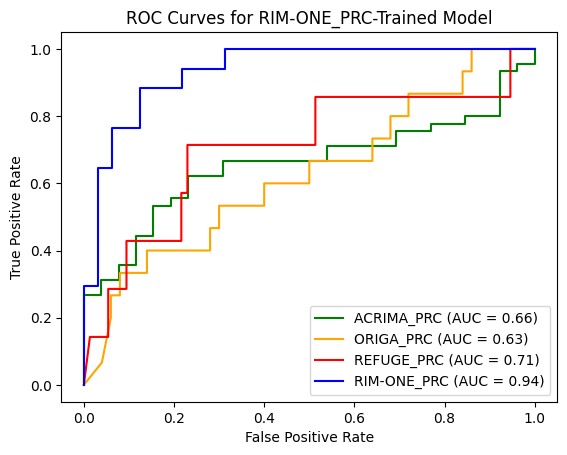

In [43]:
# AUC PLOT FOR ALL DATASETS
colors = ['green', 'orange', 'red', 'blue']

# create empty figure
plt.figure()
i = 0

for test_set in test_sets:
  test_dir = '/content/drive/MyDrive/Thesis/' + test_set + '_ROI/test/'

  # load and normalize test set by training means and std. devs.
  test_data = ImageFolder(test_dir, transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor(), transforms.Normalize(mean=datasets[finetuned]['means'], std=datasets[finetuned]['stds'])]))
  test_loader = DataLoader(dataset=test_data, batch_size = len(test_data), shuffle=False)

  # collect softmax and labels, and return AUC score and ROC measures
  score, fpr, tpr = collect_auc_roc(model, test_loader)

  # print AUC score for each test set
  print(test_set + " AUC score: " + str(score))

  # add ROC curve to plot for each test set
  plt.plot(fpr, tpr, label=test_set + " (AUC = " + str(round(score,2)) + ")", color=colors[i])
  i += 1

# show and save plot with all 4 test set curves
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for " + finetuned + "-Trained Model")
plt.legend()
plt.savefig('/content/drive/MyDrive/Thesis/ROC curve plots/' + finetuned + '_ROC_curve.png')
plt.show()